In [29]:
import json
import torch
import pandas as pd
import numpy as np
from torch_geometric.data import Data

In [2]:
df = pd.read_csv("../data/articles_filtered_categories.csv")

In [3]:
df['category'] = df['deepseek_answer'].apply(lambda x: x.split("</think>")[-1].strip().split('\n')[0].strip())

In [4]:
df['category'].value_counts(normalize=True)

category
Other                                         0.663096
Systems & Hardware                            0.098437
Programming & Software                        0.062390
Mathematics & Formal Methods                  0.052559
Data Management & Databases                   0.037560
Networking & Protocols                        0.032014
Computer Security                             0.029493
Artificial Intelligence & Machine Learning    0.024452
Name: proportion, dtype: float64

As we can see, the articles dataset is imbalanced. Let’s drop a portion of the articles that have ‘Other’ as their target label.

In [5]:
mask_other = df['category'] == 'Other'
other_indices = df[mask_other].index

# Choose 30% of records randomly
drop_size = int(len(other_indices) * 0.3)
drop_indices = np.random.choice(other_indices, size=drop_size, replace=False)

df_filtered = df.drop(drop_indices).reset_index(drop=True)
df_filtered['idx'] = list(range(len(df_filtered)))

Now, let's assign the correct labels to each node

In [6]:
with open("../data/wiki_graph_filtered_v2.json") as f:
    data = json.load(f)

nodes_dict = data["nodes"]
edges_list = data["edges"]

In [7]:
idx2category = dict(zip(df_filtered['idx'], df_filtered['category']))
title2idx = dict(zip(df_filtered['title'], df_filtered['idx']))
title2category = dict(zip(df_filtered['title'], df_filtered['category']))

In [8]:
for article_id, node in nodes_dict.items():
    node['idx'] = title2idx.get(article_id, None)
    node['category'] = title2category.get(article_id, None)

### Creating Node Features

To construct the node features, we will use google/embeddinggemma-300m.
This model is lightweight enough to run comfortably on a laptop (300M parameters) while still delivering competitive performance — it currently ranks 10th on the MTEB leaderboard.

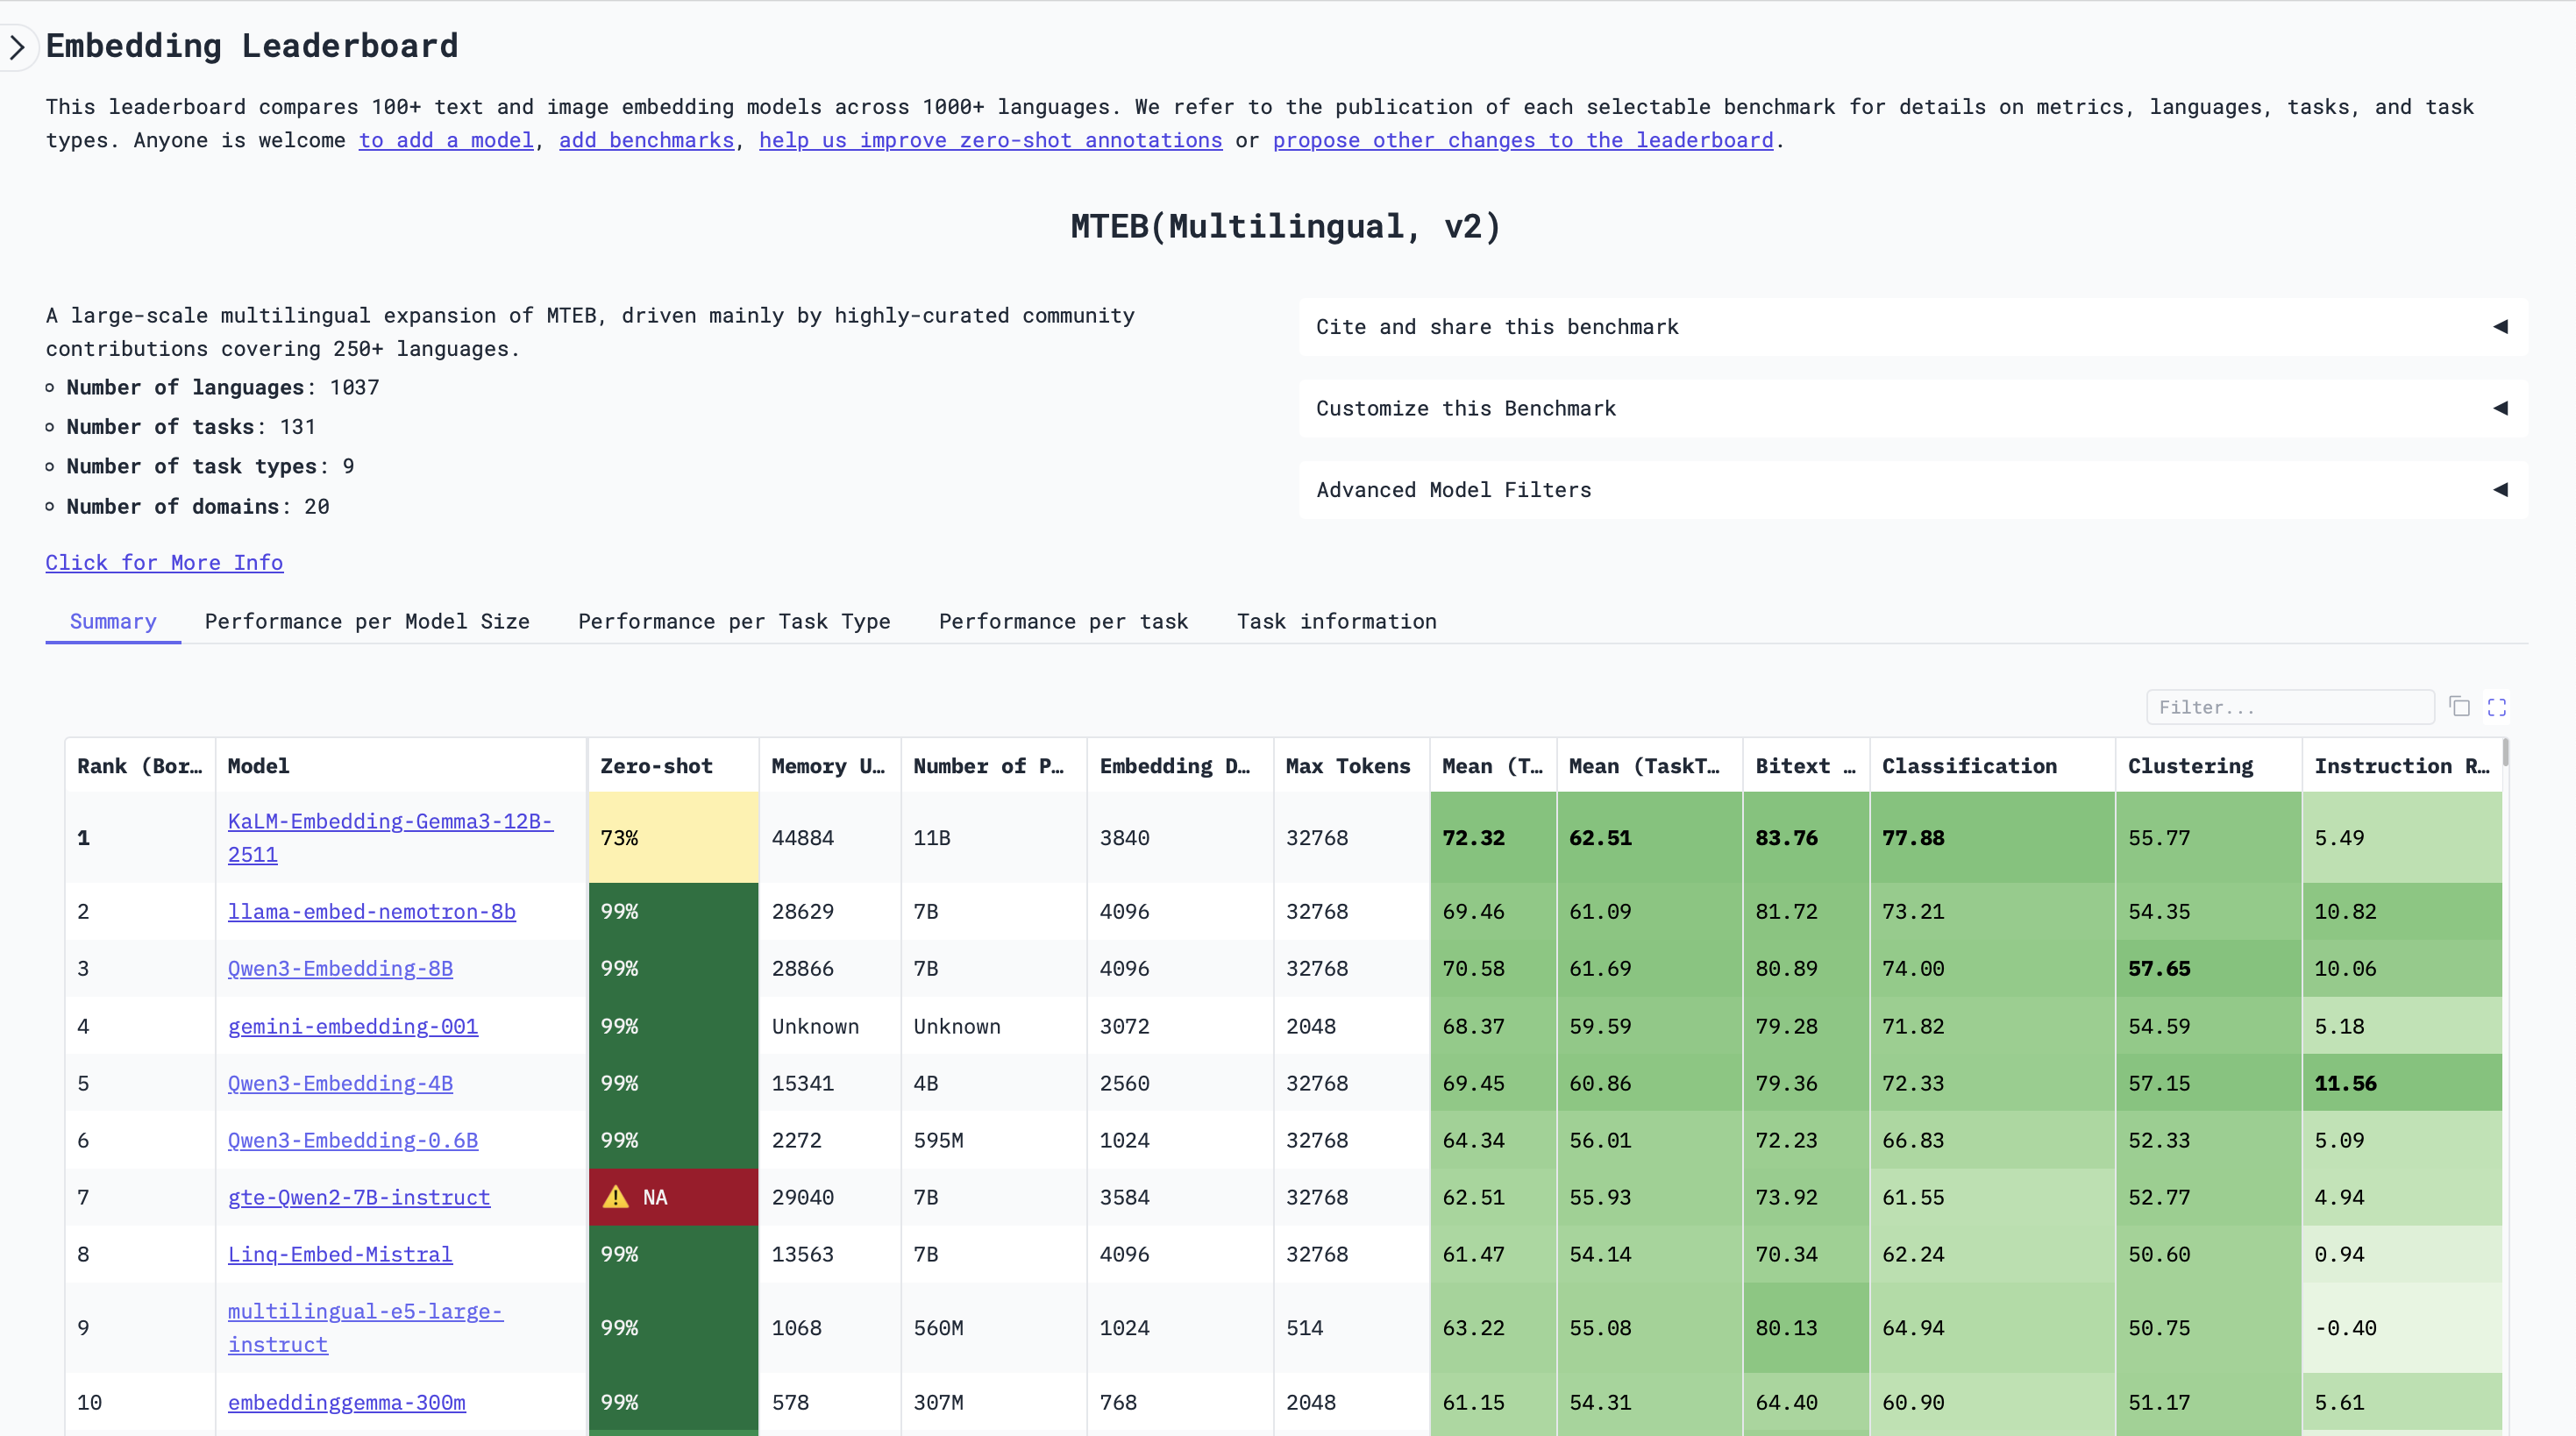

In [16]:
from textwrap import shorten
from sentence_transformers import SentenceTransformer

model_name: str = "google/embeddinggemma-300m"
print(f"[INFO] Loading embedding model: {model_name}")
model = SentenceTransformer(model_name, device="mps", truncate_dim=384)

# Prepare texts with character limit
query_prompts = [
    shorten(node.get("text", ""), width=750)
    for node in nodes_dict.values()
]

# Embed nodes (queries)
print("[INFO] Generating nodes embeddings...")
query_embeddings = model.encode(
    query_prompts,
    batch_size=4,               
    show_progress_bar=True,      
    convert_to_numpy=True,       
    normalize_embeddings=True   
)

print(f"[INFO] Generated embeddings shape: {query_embeddings.shape}")

[INFO] Loading embedding model: google/embeddinggemma-300m


You are trying to use a model that was created with Sentence Transformers version 5.1.0, but you're currently using version 4.1.0. This might cause unexpected behavior or errors. In that case, try to update to the latest version.


[INFO] Generating nodes embeddings...


Batches:   0%|          | 0/1984 [00:00<?, ?it/s]

[INFO] Generated embeddings shape: (7934, 384)


In [19]:
source_indices = []
target_indices = []

for src_title, tgt_title in edges_list:
    if src_title in title2idx and tgt_title in title2idx:
        source_indices.append(title2idx[src_title])
        target_indices.append(title2idx[tgt_title])

edge_index = torch.tensor([source_indices, target_indices], dtype=torch.long)
print(f"[INFO] Edge index shape: {edge_index.shape}")

[INFO] Edge index shape: torch.Size([2, 5536])


In [31]:
unique_categories = df_filtered['category'].unique()
category2label = {cat: i for i, cat in enumerate(unique_categories)}

In [33]:
node_indices = [node.get("idx") for node in nodes_dict.values()]
valid_embeddings = []
node_labels = []

for j, idx in enumerate(node_indices):
    if idx is not None:
        valid_embeddings.append(query_embeddings[j])
        label = category2label[idx2category[idx]]
        node_labels.append(label)

valid_embeddings = torch.tensor(valid_embeddings, dtype=torch.float32)
node_labels = torch.tensor(node_labels, dtype=torch.long)


data = Data(x=valid_embeddings, edge_index=edge_index, y=node_labels)

print(data)

Data(x=[6356, 384], edge_index=[2, 5536], y=[6356])


/var/folders/8r/zrjm4hxd2752djqdmtnnvk700000gn/T/ipykernel_53045/3622222395.py:11: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:256.)
  valid_embeddings = torch.tensor(valid_embeddings, dtype=torch.float32)


[INFO] Root node: Attribute domain (idx=1302)


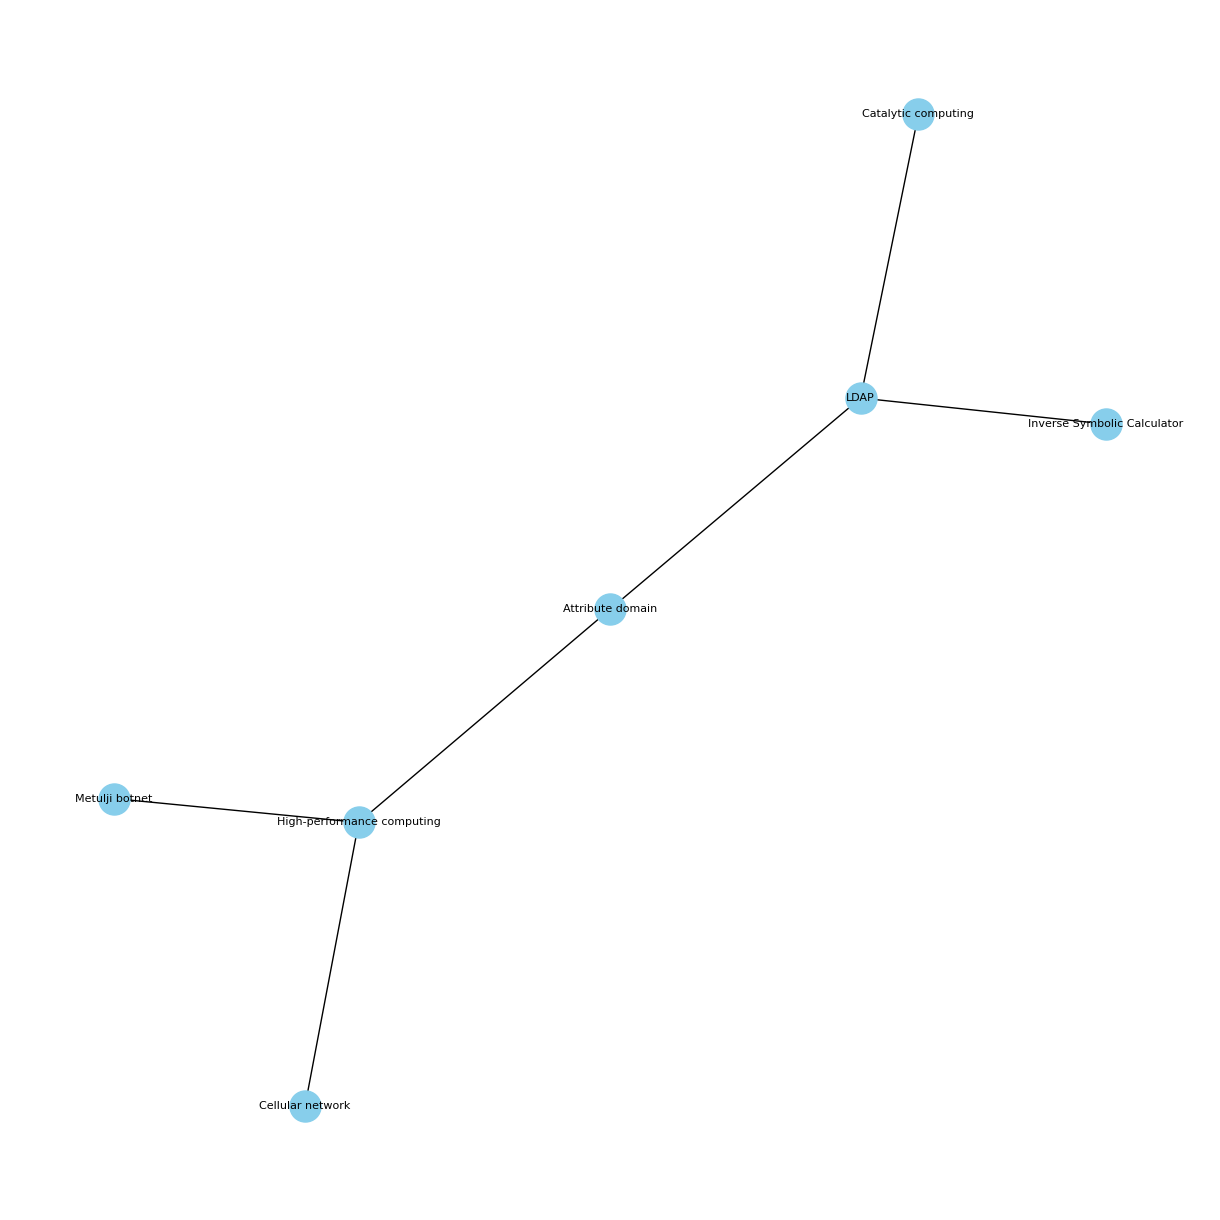

In [64]:
import random

from torch_geometric.utils import k_hop_subgraph, to_networkx
import networkx as nx
import matplotlib.pyplot as plt


root_idx = random.choice(range(data.num_nodes))
root_title = list(nodes_dict.keys())[root_idx]
print(f"[INFO] Root node: {root_title} (idx={root_idx})")

k = 2 

subset, sub_edge_index, mapping, edge_mask = k_hop_subgraph(
    node_idx=root_idx,
    num_hops=k,
    edge_index=data.edge_index,
    relabel_nodes=True
)

sub_x = data.x[subset]
sub_y = data.y[subset]

G = to_networkx(
    Data(x=sub_x, edge_index=sub_edge_index, y=sub_y),
    to_undirected=True
)

title_subset = [list(nodes_dict.keys())[i] for i in subset.tolist()]
nx.set_node_attributes(G, {i: title for i, title in enumerate(title_subset)}, "title")

plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, seed=42)
nx.draw(
    G,
    pos,
    with_labels=True,
    labels=nx.get_node_attributes(G, 'title'),
    node_size=500,
    font_size=8,
    node_color='skyblue'
)
plt.show()